## Libraries

In [1]:
import pandas as pd
import numpy as np
from numpy import percentile
import matplotlib.pyplot as plt
from scipy.stats import norm
import scipy.stats as st

import warnings
warnings.filterwarnings("ignore")

%matplotlib inline

## Data Prep

In [2]:
df = pd.read_csv('set.csv')
df.head()

,Date,Value_Out
0,2020-01-06,1.354521e+06
1,2020-01-07,1.216562e+08
2,2020-01-09,1.017467e+08
3,2020-01-10,2.143202e+04
4,2020-01-12,3.181721e+08


In [3]:
df['Date'] = pd.to_datetime(df['Date'])

In [4]:
df = df.set_index('Date')

In [5]:
df = df.resample('W-FRI').sum()

In [6]:
df.head()

,Value_Out
Date,
2020-01-10,2.247789e+08
2020-01-17,1.671836e+09
2020-01-24,1.928003e+09
2020-01-31,5.223685e+09
2020-02-07,3.162360e+09


    y = log(x)
    x = 10 ** y

## Monte Carlo Forecasting - Test

In [7]:
def test(data, train_size, num_sims, col):
    
    y=np.log10(data[col])
    data['log'] = y
    data = data.drop(col, axis = 1)
        
    train = data[:round(data.shape[0] * train_size)]
    test = data[round(data.shape[0] * train_size):]
    train['log_vals'] = train.pct_change()
    train['log_vals'] = train['log_vals'].replace([np.inf, -np.inf], train['log_vals'].median())
    change = train['log_vals']

    last_val = train['log'][-1]

    num_simulations = num_sims

    num_days = len(test)
    simulations_df = pd.DataFrame()
    
    for x in range(num_simulations):
        ## Keeping a count for total no of days o.e. break when we hit our num_days target
        count = 0
        daily_vol = change.std()

        ## A list to append the prices for the period we are calculating
        series = []

        ## We need to get the list going with one initial cashflow value using a random shock i.e. np.random.normal
        ## This will generate our future stock prices randomly
        val = last_val * (1 + np.random.normal(0, daily_vol))
        series.append(val)

        for y in range(num_days):
            if count == num_days - 1:
                break
            value = series[count] * (1 + np.random.normal(0, daily_vol))
            series.append(value)
            count += 1

        simulations_df[x] = series
        
    cols = list(simulations_df.T.columns)
    ninety = []
    seven_five = []
    twenty_five = []
    ten =  []

    for i in range(len(cols)):
        ninety.append(np.percentile(list(simulations_df.T[cols[i]]), 90))
        seven_five.append(np.percentile(list(simulations_df.T[cols[i]]), 75))
        ten.append(np.percentile(list(simulations_df.T[cols[i]]), 10))
        twenty_five.append(np.percentile(list(simulations_df.T[cols[i]]), 25))
        
    ## Creating a dataframe of the averages for each day and relevant percentiles
    av = pd.DataFrame(simulations_df.median(axis = 1), columns = ['Average'])
    sf = pd.DataFrame(seven_five, columns = ['P75'])
    tf = pd.DataFrame(twenty_five, columns = ['P25'])
    nt = pd.DataFrame(ninety, columns = ['P90'])
    tn = pd.DataFrame(ten, columns = ['P10'])

    pred_df = pd.concat([av,sf,tf,nt,tn], axis = 1)
    
    ## Plotting it all here
    plt.figure(figsize = (17,5))

    plt.plot(pred_df['P90'], label = 'P90', ls = '-', lw = 0.1)
    plt.plot(pred_df['P75'], label = 'P75', ls = '-', lw = 0.1)
    plt.plot(pred_df['Average'], label = 'Average Pred', marker = 'o', c = 'black')
    plt.plot(list(test['log']), label = 'Test', marker = 'o', c = 'green')

    plt.fill_between(pred_df.index, pred_df['Average'], pred_df['P75'], color = 'yellow', alpha = 1.0)
    plt.fill_between(pred_df.index, pred_df['Average'], pred_df['P25'], color = 'yellow', alpha = 1.0)

    plt.fill_between(pred_df.index, pred_df['Average'], pred_df['P90'], color = 'orange', alpha = 0.2)
    plt.fill_between(pred_df.index, pred_df['Average'], pred_df['P10'], color = 'orange', alpha = 0.2)

    plt.plot(pred_df['P25'], label = 'P25', ls = '-', lw = 0.1)
    plt.plot(pred_df['P10'], label = 'P10', ls = '-', lw = 0.1)

    plt.legend(loc = 'upper left')
    plt.grid(alpha = 0.2, c = 'r')

    plt.xlabel('Forecast Timeline')
    plt.ylabel(data.columns[0])
    plt.title('Forecast')

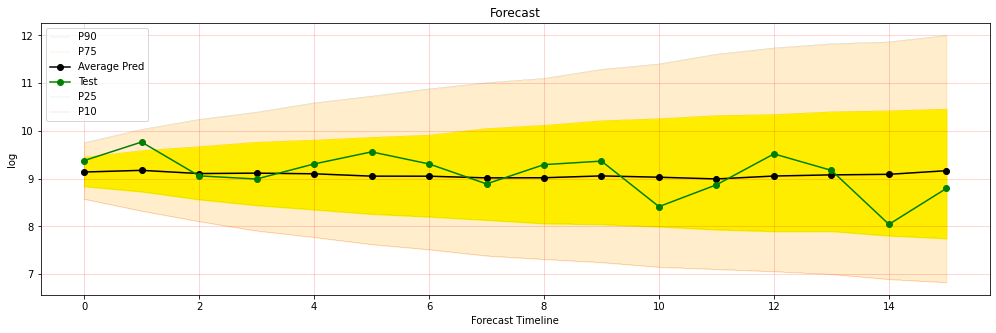

In [8]:
data = df
train_size = 0.70
num_sims = 1000
col = 'Value_Out'

test(data, train_size, num_sims, col)

## Monte Carlo Forecasting - Out of Sample

In [9]:
def forecast(data, num_sims, col, frequency, duration):
    
    y=np.log10(data[col])
    data['log'] = y
    data = data.drop(col, axis = 1)
    
    data['log_vals'] = data.pct_change()
    data['log_vals'] = data['log_vals'].replace([np.inf, -np.inf], data['log_vals'].median())
    change = data['log_vals']
    last_val = data['log'][-1]

    ## No of Simulations
    num_simulations = num_sims
    num_days = duration
    simulations_df = pd.DataFrame()
    
    for x in range(num_simulations):
        count = 0
        daily_vol = change.std()

        series = []

        val = last_val * (1 + np.random.normal(0, daily_vol))
        series.append(val)

        for y in range(num_days):
            if count == num_days - 1:
                break
            value = series[count] * (1 + np.random.normal(0, daily_vol))
            series.append(value)
            count += 1

        simulations_df[x] = series
        
    cols = list(simulations_df.T.columns)
    ninety = []
    seven_five = []
    twenty_five = []
    ten =  []

    for i in range(len(cols)):
        ninety.append(np.percentile(list(simulations_df.T[cols[i]]), 90))
        seven_five.append(np.percentile(list(simulations_df.T[cols[i]]), 75))
        ten.append(np.percentile(list(simulations_df.T[cols[i]]), 10))
        twenty_five.append(np.percentile(list(simulations_df.T[cols[i]]), 25))
        
    future_dates = pd.date_range(start = data.index[-1], periods = num_days+1, freq = frequency).to_pydatetime().tolist()
    
    del future_dates[0]
    
    av = pd.DataFrame(simulations_df.median(axis = 1), columns = ['Average'])
    fut = pd.DataFrame(future_dates, columns = ['Date'])
    sf = pd.DataFrame(seven_five, columns = ['P75'])
    tf = pd.DataFrame(twenty_five, columns = ['P25'])
    nt = pd.DataFrame(ninety, columns = ['P90'])
    tn = pd.DataFrame(ten, columns = ['P10'])

    pred_df = pd.concat([fut,av,sf,tf,nt,tn], axis = 1)
    pred_df = pred_df.set_index('Date')
    
    plt.figure(figsize = (10,6))
    plt.plot(pred_df['P90'], ls = '-', lw = 0.1)
    plt.plot(pred_df['P75'], ls = '-', lw = 0.1)
    plt.plot(pred_df['P25'], ls = '-', lw = 0.1)
    plt.plot(pred_df['P10'], ls = '-', lw = 0.1)

    plt.plot(pred_df['Average'], label = 'MC Average', c = 'black', ls = '--', markersize = 5)
    plt.plot(data[data.columns[0]].tail(60), label = 'Previous 60 Data Points', c = 'blue')

    plt.fill_between(pred_df.index, pred_df['Average'], pred_df['P75'], color = 'yellow', alpha = 1.0)
    plt.fill_between(pred_df.index, pred_df['Average'], pred_df['P25'], color = 'yellow', alpha = 1.0)

    plt.fill_between(pred_df.index, pred_df['Average'], pred_df['P90'], color = 'orange', alpha = 0.2)
    plt.fill_between(pred_df.index, pred_df['Average'], pred_df['P10'], color = 'orange', alpha = 0.2)

    plt.legend(bbox_to_anchor=(1.01, 1), loc=2, borderaxespad=0.)
    plt.grid(alpha = 0.2, c = 'r')

    plt.xlabel('Forecast Timeline')
    plt.ylabel(data.columns[0])

    plt.title('Forecast')

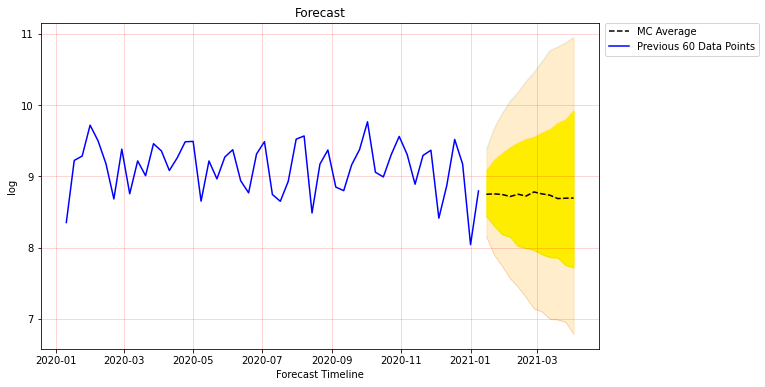

In [10]:
data = df
num_sims = 1000
col = 'Value_Out'
frequency = 'W-FRI'
duration = 12

forecast(data, num_sims, col, frequency, duration)

In [11]:
def forecast_df(data, num_sims, col, frequency, duration):
    
    y=np.log10(data[col])
    data['log'] = y
    data = data.drop(col, axis = 1)
    
    data['log_vals'] = data.pct_change()
    data['log_vals'] = data['log_vals'].replace([np.inf, -np.inf], data['log_vals'].median())
    change = data['log_vals']
    last_val = data['log'][-1]

    ## No of Simulations
    num_simulations = num_sims
    num_days = duration
    simulations_df = pd.DataFrame()
    
    for x in range(num_simulations):
        count = 0
        daily_vol = change.std()

        series = []

        val = last_val * (1 + np.random.normal(0, daily_vol))
        series.append(val)

        for y in range(num_days):
            if count == num_days - 1:
                break
            value = series[count] * (1 + np.random.normal(0, daily_vol))
            series.append(value)
            count += 1

        simulations_df[x] = series
        
    cols = list(simulations_df.T.columns)
    ninety = []
    seven_five = []
    twenty_five = []
    ten =  []

    for i in range(len(cols)):
        ninety.append(np.percentile(list(simulations_df.T[cols[i]]), 90))
        seven_five.append(np.percentile(list(simulations_df.T[cols[i]]), 75))
        ten.append(np.percentile(list(simulations_df.T[cols[i]]), 10))
        twenty_five.append(np.percentile(list(simulations_df.T[cols[i]]), 25))
        
    future_dates = pd.date_range(start = data.index[-1], periods = num_days+1, freq = frequency).to_pydatetime().tolist()
    
    del future_dates[0]
    
    av = pd.DataFrame(simulations_df.median(axis = 1), columns = ['Average'])
    fut = pd.DataFrame(future_dates, columns = ['Date'])
    sf = pd.DataFrame(seven_five, columns = ['P75'])
    tf = pd.DataFrame(twenty_five, columns = ['P25'])
    nt = pd.DataFrame(ninety, columns = ['P90'])
    tn = pd.DataFrame(ten, columns = ['P10'])

    pred_df = pd.concat([fut,av,sf,tf,nt,tn], axis = 1)
    pred_df = pred_df.set_index('Date')
    
    ## Reversing from log transform back to normal predictions
    cols = pred_df.columns
    pred_df_final = 10 ** pred_df[cols]
    pred_df_final[cols] = pred_df_final[cols].astype('int64')
    
    return pred_df_final

In [12]:
data = df
num_sims = 1000
col = 'Value_Out'
frequency = 'W-FRI'
duration = 12

pred_df_final = forecast_df(data, num_sims, col, frequency, duration)

In [13]:
pred_df_final

,Average,P75,P25,P90,P10
Date,,,,,
2021-01-15,656121971,1300999909,305116840,2526302914,160707170
2021-01-22,601156469,1668670873,225212830,4347318519,92826549
2021-01-29,573528580,1876948403,166200973,6161869887,63705188
2021-02-05,581059893,2650387105,140595676,10248494093,47645955
2021-02-12,616305751,3584840815,119026149,14917178147,30510563
2021-02-19,554114655,4286697831,94941555,22805386581,20747807
2021-02-26,599436680,4356681728,76173217,30890687714,17565976
2021-03-05,616815362,4913171525,63897490,46408207658,13307381
2021-03-12,602642846,6265918001,62778158,57310862775,10563129
